## IFT 3700 - 21 Décembre 2018 - Travail 2
### David Ogaus(1004183), Jonathan Caspar (20059041), Tommy Côté(1056362) et Xiuli Zhang (20039439)
------------

## Question 1
---------
Cette question est une compétition entre les équipes et sera évaluée en fonction de la précision du classifieur produit par chaque équipe. Les données sont contenues dans le fichier PATCH.amat et il s’agit de 50000 images (28 x 28) en noir et blanc codées en binaire. Les images sont abstraites et appartiennent à deux catégories distinctes. Le fichier contient une image par ligne et chaque ligne commence par 784=28 * 28 bits associés à la couleur des pixels et suivi d’un bit représentant la classe. Le codage du fichier est lisible, mais nécessite un prétraitement pour être utilisé. L’équipe doit produire un classifieur qui sera mis en production et évalué sur des données fraîches non disponibles à l’équipe (mais qui ont exactement la même distribution). Les équipes avec une solution minimalement raisonnable seront classées en ordre de précision et le rang sera transformé en note variant de 10 à 25 sur 25.

![DataShape](datashape.jpg)

### Importation du fichier PATCH.amat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
file = open("PATCH.amat")
rawData = list(file) # contient une liste de 50.000 vecteurs
#print(rawData)

In [3]:
regex = re.compile("\s*(0|1)\.") # expression régulière qui extrait chaque chiffre (0 ou 1) situé avant un point
data, label = [], []

for vector in rawData :
    parsedVector = re.findall(regex, vector)
    intVector = [int(pixel.strip()) for pixel in parsedVector]
    label.append(intVector.pop(784)) # on retire le dernier bit correspondant à la classe du vecteur et on l'ajoute dans label
    data.append(intVector) # on ajoute le vecteur de pixels (auquel on a retiré le dernier bit) dans "data"
    
features = np.array(data)
targets = np.array(label)
print(np.shape(features))
print(np.shape(label))

(50000, 784)
(50000,)


En convertissant nos vecteurs en matrice 28 x 28, on peut visualiser quelques vecteurs de **classe 0** et de **classe 1** :

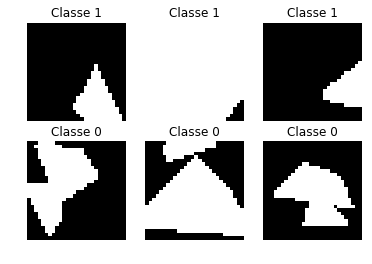

In [4]:
# Extraction d'échantillons
dataSample = [data[i] for i in range(4000,4003)] + [data[i] for i in range(40000,40003)]
labelSample = [label[i] for i in range(4000,4003)] + [label[i] for i in range(40000,40003)]
#print(dataSample)
# Affichage de chaque échantillon et leurs classes respectives
for i, vector in enumerate(dataSample):
    ax = plt.subplot(2,3,i+1)
    plt.axis('off')
    ax.set_title("Classe " + str(labelSample[i]))
    matrix = np.reshape(vector, (28,28))
  #  matrix.append(np.array(Image.open(file).resize((75, 75))))
    plt.imshow(matrix, cmap='gray')

# Jeu d'entrainement / Jeu de validation

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features, targets, test_size=0.05, random_state=42)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

X_train.shape (47500, 784)
X_valid.shape (2500, 784)
y_train.shape (47500,)
y_valid.shape (2500,)


In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Placeholder
x = tf.placeholder(tf.float32, (None, 28,28,3), name="x")
y = tf.placeholder(tf.float32, (None, 1, 1,3), name="y")
dropout = tf.placeholder(tf.float32, (None), name="dropout")

def create_conv(prev, filter_size, nb):
    # First convolution
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, int(prev.get_shape()[-1]), nb)))
    conv_b = tf.Variable(tf.zeros(nb))
    conv   = tf.nn.conv2d(prev, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b
    # Activation: relu
    conv = tf.nn.relu(conv)
    # Pooling
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return conv

conv = create_conv(x, 8, 32)
conv = create_conv(conv, 5, 64)
conv = create_conv(conv, 5, 128)
conv = create_conv(conv, 5, 256)
conv = create_conv(conv, 5, 512)

flat = flatten(conv)
print(flat, flat.get_shape()[1])

# First fully connected layer
fc1_W = tf.Variable(tf.truncated_normal(shape=(int(flat.get_shape()[1]), 512)))
fc1_b = tf.Variable(tf.zeros(512))
fc1   = tf.matmul(flat, fc1_W) + fc1_b

# Activation.
fc1    = tf.nn.relu(fc1)

#fc1 = tf.nn.dropout(fc1, keep_prob=dropout)

# Last layer: Prediction
fc3_W  = tf.Variable(tf.truncated_normal(shape=(512, 2)))
fc3_b  = tf.Variable(tf.zeros(2))
logits = tf.matmul(fc1, fc3_W) + fc3_b

softmax = tf.nn.softmax(logits)

C:\Users\moi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor("Flatten/flatten/Reshape:0", shape=(?, 512), dtype=float32) 512


In [7]:
batch_size = 255

sess =  tf.Session()
sess.run(tf.global_variables_initializer())

In [8]:
from scipy import ndimage
from scipy import misc
from random import randint
import random

def augmented_batch(batch):
    """
    """
    n_batch = []
    
    for img in batch:
        if random.uniform(0, 1) > 0.75:
            process_img = Image.fromarray(np.uint8(img.reshape(75, 75, 3))).rotate(randint(-45, 45))
            n_img = np.array(process_img)
            n_batch.append(n_img.reshape(75, 75, 3))
        else:
            n_batch.append(img)
        
    return n_batch

## Question 2
---------
Imaginez qu’on vous donne un fichier contenant des données de nature astronomique. Il s’agit de données concernant 6500 milliards d’étoiles. Les données (dépassant la centaine de téraoctets) sont réparties sur **300 serveurs** avec un accès rapide au disque et une bonne capacité de calcul. La connexion entre les serveurs est rapide, mais pas exceptionnelle.

Les données pour chaque étoile comporte, la position dans l’espace (x,y,z), la luminosité apparente de l’étoile et sa catégorie (10 catégories possibles). Aussi, pour chaque étoile une liste de ses caractéristiques physiques représentées par 22 nombres réels est incluse.

Proposez une approche distribuée qui permet de répondre aux questions suivantes et expliquez en détail toute la démarche permettant leur résolution.
* Trouvez les 1000 paires d’étoiles jumelles les plus proches (distance euclidienne de la position).
* Comptez combien d'étoiles il y a dans chaque catégorie.
* Produisez un classifieur qui, étant donné le vecteur de caractéristiques (22 nombres réels), prédit la catégorie de l’étoile.


>> Epoch: 0


NameError: name 'Image' is not defined

## Question 3
---------
Expliquez en détail comment utiliser un classifieur binaire, capable d’apprendre à effectuer la classification de deux catégories, pour réaliser la classification dans un contexte ou plusieurs catégories doivent être distinguées. Considérez le cas à 3, 25, 12500 catégories et faite le contraste entre les différentes approches étudiées et le nombre de catégories.

Plusieurs strategies permettant de d'utiliser un classifieur binaire pour realiser la classification dans le cas de plusieurs categories telles que 

approche 1

Construire N (N-1) classificateurs, un classificateur pour les distinguer chaque paire de classes i and j. Soit
fij le classificateur où la classe i sont des exemples positifs et la classe j des exemples négatifs. Note $f_{ji} = -f_{ij}$. Classifier en utilisant: $f(x)= arg max_i \sum_j f_{ij}$

Vu naïvement, la deuxieme pproche semble plus rapide et plus efficace en termes de mémoire.
Il nécessite des classificateurs O (N2) au lieu de O (N), mais
chaque classificateur est (en moyenne) beaucoup plus petit. Si le temps de
construire un classificateur est superlineaire dans le nombre de points de données,
le deuxieme est un meilleur choix. Avec les SVM, AVA est probablement le meilleur.
Cependant, si vous pouvez résoudre un problème RLS sur l’ensemble de votre
ensemble de données en utilisant une factorisation matricielle, vous obtenez multiclass
classification essentiellement gratuite (voir la conférence RLS). Alors
avec RLS, OVA est un excellent choix.

Il existe d'autres approches de base pour étendre la classification binaire a une classification multiclasse:
• Approche «machine simple» - essayez de résoudre une seule
problème d'optimisation qui entraîne de nombreux classificateurs binaires
simultanément.
• Approche du «code de correction d'erreur» - essayez de combiner les
classificateurs binaires d'une manière qui vous permet d'exploiter les décorrélations
et corriger les erreurs..... a completer pour les contrastes



## Question 4
---------
Faites une analyse détaillée et exhaustive des patrons existants dans le jeu de données adulte. Il est possible que le regroupement de valeurs pour certaines caractéristiques donne des résultat intéressant. Vous devez aussi, s’il y a lieux, discuter de l’aspect éthique concernant l’utilisation des patrons obtenus.

In [20]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [86]:
freq = {}
history = []
caracteristiques = {}
idx = 0

with open('adult.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=' ')
    for i, row in enumerate(reader):            
        history.append(row[:-1])
        
        for patron in row[:-1]:
            if patron not in caracteristiques:
                caracteristiques[patron] = idx
                freq[idx] = 1
                idx += 1
            else:
                freq[caracteristiques[patron]] += 1 

(array([2.2139e+04, 7.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 6.0900e+03, 1.2179e+04, 1.8268e+04, 2.4357e+04,
        3.0446e+04, 3.6535e+04, 4.2624e+04, 4.8713e+04, 5.4802e+04,
        6.0891e+04]),
 <a list of 10 Patch objects>)

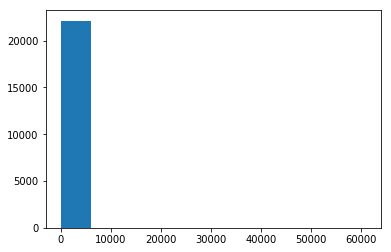

In [80]:
plt.hist(list(freq.values()))

In [81]:
Utilisons un $s$ de 1% des baskets, c'est-à-dire que nous garderons seulement les éléments dont la fréquence est de plus de `float(len(history))/100`.

SyntaxError: invalid syntax (<ipython-input-81-6b471042665b>, line 1)

In [82]:
s = float(len(history))/100
frequent_patron = [k for k, v in freq.items() if v > s]

In [83]:
len(frequent_patron)

115

In [84]:
Maintenant, nous pouvons faire la deuxième passe qui consiste à trouver les paires constituées par les produits fréquents. Au lieu d'avoir des paires parmi 12000 éléments, nous avons des paires parmi 230 éléments.

SyntaxError: invalid syntax (<ipython-input-84-5afbab12fddc>, line 1)

In [85]:
len(history)
print(caracteristiques)

{'Age,': 0, 'workclass,': 1, 'fnlwgt,': 2, 'education,': 3, 'education-num,': 4, 'marital-status,': 5, 'occupation,': 6, 'relationship,': 7, 'race,': 8, 'sex,': 9, 'capital-gain,': 10, 'capital-loss,': 11, 'hours-per-week,': 12, 'native-country,': 13, '39,': 14, 'State-gov,': 15, '77516,': 16, 'Bachelors,': 17, '13,': 18, 'Never-married,': 19, 'Adm-clerical,': 20, 'Not-in-family,': 21, 'White,': 22, 'Male,': 23, '2174,': 24, '0,': 25, '40,': 26, 'United-States,': 27, '50,': 28, 'Self-emp-not-inc,': 29, '83311,': 30, 'Married-civ-spouse,': 31, 'Exec-managerial,': 32, 'Husband,': 33, '38,': 34, 'Private,': 35, '215646,': 36, 'HS-grad,': 37, '9,': 38, 'Divorced,': 39, 'Handlers-cleaners,': 40, '53,': 41, '234721,': 42, '11th,': 43, '7,': 44, 'Black,': 45, '28,': 46, '338409,': 47, 'Prof-specialty,': 48, 'Wife,': 49, 'Female,': 50, 'Cuba,': 51, '37,': 52, '284582,': 53, 'Masters,': 54, '14,': 55, '49,': 56, '160187,': 57, '9th,': 58, '5,': 59, 'Married-spouse-absent,': 60, 'Other-service,'

In [69]:
n = len(frequent_patron)
pair = np.zeros((n, n)) 
# ici, nous utilisons une matrice complète. Il est naturellement possible d'utiliser la méthode triangulaire...

for basket in history:
    for i in range(len(basket)):
        for j in range(i, len(basket)):
            p1 = caracteristiques[basket[i]]
            p2 = caracteristiques[basket[j]]
            
            if p1 > p2:
                p1, p2 = p2, p1
            if p1 in frequent_patron and p2 in frequent_patron and p1 != p2:
                p1_idx = frequent_patron.index(p1)
                p2_idx = frequent_patron.index(p2)
                pair[p1_idx, p2_idx] += 1 

In [74]:
np.unravel_index(pair.argmax(), pair.shape)
#len(pair)

(9, 11)


ModuleNotFoundError: No module named 'graphviz'

In [78]:
len(caracteristiques)
#print(market)

NameError: name 'caracteristiques' is not defined

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df[df['gender'] == 'Male']['educational-num'].head()